**извлечение признаков из текста на естественном языке**

классификатор текстов

частотный анализ с очисткой стоп-слов (TF)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import pandas as pd
import re
import gzip

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200  

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [6]:
data.sample(2)

,text,tag
2343,"13 декабря 2016, 01:56\n\nСемья из трех человек погибла в результате отравления газом в Ростове-на-Дону\n\nУгарный газ скопился во время работы отопительного котла при замусоренном дымоходе, заяви...",incident
2082,"Футболисты римской «Ромы» в домашнем матче 16-го тура чемпионата Италии переиграли «Милан».\n\nВстреча, прошедшая в понедельник в Риме на стадионе «Олимпико», завершилась со счетом 1:0 в пользу хо...",sport


---

In [9]:
# from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian') )

In [10]:
# with gzip.open('../data/text/stop-nltk.txt.gz','rt',encoding='utf-8') as f: 
#     stopwords = set([ w.strip() for w in  f.read().split() if w.strip() ] )

print('количество стоп-слов:',len(stopwords))
# sorted(stopwords)

количество стоп-слов: 151


In [11]:
%%time 

data['text_clean'] = data['text'].str.lower() # приведение в lowercase

# замена символов-разделителей (-,_) на пробел
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'_', ' ', s))

# замена цифр
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' ', s))

# делим строки на слова (токенизация)
data['text_clean'] = data['text_clean'].apply(lambda t: [ w.strip() for w in t.split() if len(w.strip())>2 ] )

# удаление лишних слов 
data['text_clean'] = data['text_clean'].apply(lambda t:[w for w in t if w not in stopwords])

# стемминг, выделение основы слова
# data['text_clean'] = data['text_clean'].apply( lambda t: Stemmer('russian').stemWords(t) )
# data['text_clean'] = data['text_clean'].apply(lambda t:[ SnowballStemmer('russian').stem(w) for w in t if w])


CPU times: user 587 ms, sys: 37.6 ms, total: 625 ms
Wall time: 625 ms


In [12]:
data['text_clean'] = data['text_clean'].apply(lambda t:' '.join(t))

In [13]:
data[['text_clean']].sample(2)

,text_clean
389,авторская передача паши корейца эфире мегаполиса ноября часов радиостанции мегаполис необычном формате ток шоу выйдет передача новой авторской программы паши корейца танцпол специальным гостем зая...
461,минфин украины финансирование евровидения полностью обеспечено декабря тасс финансирование международного песенного конкурса евровидение который должен пройти году киеве полностью обеспечено заяви...


##  HashingVectorizer

In [14]:
from sklearn.feature_extraction.text import HashingVectorizer

tf = HashingVectorizer(n_features=16384, norm='l2')
tf.fit( data['text_clean'])

HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
                  decode_error='strict', dtype=<class 'numpy.float64'>,
                  encoding='utf-8', input='content', lowercase=True,
                  n_features=16384, ngram_range=(1, 1), norm='l2',
                  preprocessor=None, stop_words=None, strip_accents=None,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

## формируем датасеты

In [15]:
X = tf.transform( data['text_clean'] )
X.shape

(3196, 16384)

In [16]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [17]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

---

In [18]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.9, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((319, 16384), (319,), (2877, 16384), (2877,))

## обучаем

In [19]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.19,
              validation_fraction=0.1, verbose=0, warm_start=False)

## тестируем

In [20]:
o = clf.predict(X_train)

In [21]:
accuracy_score(y_train,o)

1.0

---

In [22]:
o = clf.predict(X_test)

In [23]:
accuracy_score(y_test,o)

0.7417448731317344

In [24]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       227
           1       0.69      0.71      0.70       319
           2       0.71      0.70      0.71       240
           3       0.49      0.28      0.36        86
           4       0.83      0.82      0.82       396
           5       0.78      0.89      0.83       542
           6       0.42      0.28      0.33        58
           7       0.46      0.44      0.45        41
           8       0.70      0.92      0.79       200
           9       0.56      0.17      0.26       133
          10       0.86      0.89      0.87       340
          11       0.67      0.68      0.68       262
          12       0.43      0.61      0.50        33

    accuracy                           0.74      2877
   macro avg       0.65      0.62      0.62      2877
weighted avg       0.73      0.74      0.73      2877



---

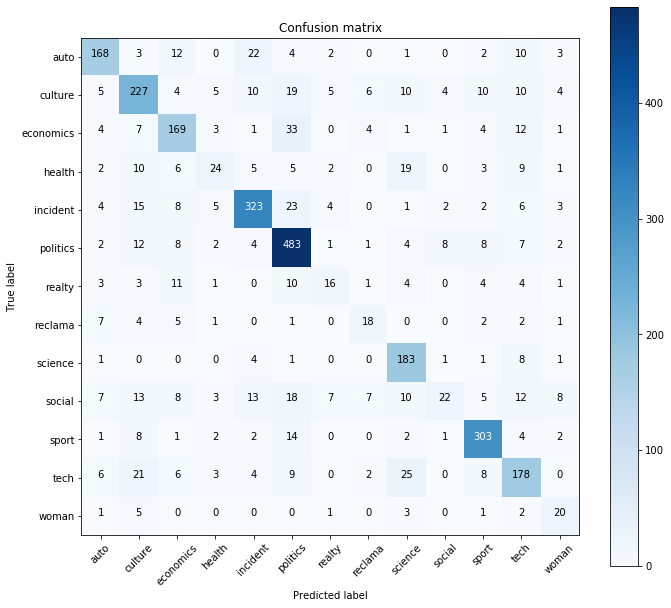

In [25]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [26]:
o = clf.predict(X)

In [27]:
labels_inv = { labels[k]:k for k in labels}
# labels_inv

In [28]:
i = np.random.randint(len(data))
print('tag:',data.iloc[i,1])
print('predict:',labels_inv[o[i]])
print('- - - - - - - - - - - - - - - - - - \n')
print(data.iloc[i,0])


tag: incident
predict: incident
- - - - - - - - - - - - - - - - - - 

Сильнейшие волны затопили первые этажи гостиниц в Сочи

4 декабря 2016 в 9:38

Newsru

Сильный шторм, ставший частью бушующей в Сочи уже вторые сутки стихии, смог преодолеть берегозащитные сооружения и обрушился на придомовые территории и детские площадки, сообщает Maks Portal.

На записи, размещенной на видеохостинге YouTube, можно наблюдать, как волны высотой в несколько метров затапливают первые этажи гостиниц, которые находятся неподалеку от берега моря.

Стихия в Сочи бушует уже вторые сутки. Ураганный ветер с порывами до 30 метров в секунду валит деревья, срывает кровлю, повреждает различные конструкции и электросети. В течение субботы было повалено порядка 160 деревьев.

В первые часы после разгула стихии власти города создали оперативный штаб. В восстановительных работах задействовано более 500 человек и почти 100 единиц техники.

Внимание! У вас отключен JavaScript, ваш браузер не поддерживает HTML5, или уст